# **微调**

标注一个数据集很贵
- 应用**迁移学习**（transfer learning）将从源数据集学到的知识迁移到目标数据集

网络架构
- 一个神经网络一般可以分为两块
  - **特征抽取**，将原始像素变成容易线性分隔的特则
  - 线性分类器来做**分类**（Softmax回归）

微调
- 源数据集——>目标数据集
  - 特征抽取：可能仍然可以对数据集做特征抽取
  - 最后一层（分类）：不能直接使用，因为标号可能变了

微调中的权重初始化：
- Pre-train
  - 将模型复制（除了最后一层）
  - 将pre-train得到的权重copy过来（除了最后一层，随机初始化，训练的也快）

训练
- 是一个目标数据集上的正常训练任务，但使用更强的正则化
  - 使用更小的学习率
  - 使用更少的数据迭代
- 源数据集远复杂于目标数据，通常微调效果更好

微调步骤
- 在源数据集上预训练神经网络模型，即源模型
- 创建一个新的神经网络模型，即目标模型
  - **复制源模型上的所有模型设计及参数**（输出层除外）
    - 假定这些模型参数包含从源数据集中学到的知识，这些知识也将适用于目标数据集
  - 不在目标模型中使用输出层
    - 假设源模型的输出层与源数据集的标签密切相关
- 向目标模型添加输出层，其输出数是目标数据集中的类别数，然后**随机初始化**该层的模型参数
- 在目标数据集上训练目标模型
  - 输出层将从头开始进行训练，而其他所有层的参数将根据源模型的参数进行微调

重用分类器权重
- 源数据集可能也有目标数据中的部分标号
- 可以使用预训练好模型分类器中对应标号对应的向量来做初始化

固定一些层
- 神经网络通常学习有层次的特征表示
  - 低层次的特征更加通用
  - 高层次的特征则更跟数据集相关
- 可以固定底部一些层的参数，不参与更新
  - 更强的正则

### 总结
- 迁移学习将从源数据集中学到的知识迁移到目标数据集，微调是迁移学习的常见技巧
- 微调通过使用在**大数据上**得到的**预训练好的模型来初始化模型权重**来完成提升精度
  - 当目标数据集比源数据集小很多时，微调有助于提高模型的泛化能力
- 预训练模型**质量**很重要
- 微调通常**速度更快、精度更高**
- 通常，微调参数使用较小的学习率，而从头开始训练输出层可以使用更大的学习率

### **注意**
- `torchvision.transforms.Compose()`中的`torchvision.transforms.ToTensor()`后的都应该是**网络架构的部分**
  - `torchvision.models.resnet18`在copy过去的时候没有copy`NormBatch`——需要**手动加入**`normalize`
  - 或者在架构最开始`NormBatch`就行
- 微调对学习率不敏感
- 在微调中，可以自己调模型
  - 比如让上层的一些动，下层的不动
  - 可以用for-loop来进行实验（微效果，贵）
- 在训练集上训练时，最好找**相近**的pretrained模型

## 代码

In [ ]:
!pip install d2l

In [ ]:
import os
import torch
import torchvision

from torch import nn
from d2l import torch as d2l

#### 热狗识别
- 配置数据集信息
  - `d2l.DATA_HUB`是一个字典，存储数据集的名称及其对应的下载地址和校验信息
    - 每个数据集的键是数据集的名称，值是一个元组，包含数据集的 URL 和校验哈希值
  - `d2l.DATA_URL + 'hotdog.zip'`：拼接成完整下载链接
  - `'fba480ffa8aa7e0febbb511d181409f899b9baa5'`是一个SHA-1哈希值
- 下载并解压数据集
  - `d2l.download_extract`从`d2l.DATA_HUB`中找到对应`hotdog`数据集，并使用相应的下载地址进行下载

In [ ]:
d2l.DATA_HUB['hotdog'] = (
    d2l.DATA_URL + 'hotdog.zip','fba480ffa8aa7e0febbb511d181409f899b9baa5'
)
data_dir = d2l.download_extract('hotdog')

- `ImageFoler`：根据文件夹结构，将`root`文件夹下**每个子文件夹视为一个类别**，**子文件夹名称**被用作类别名称
  - 数据加载后，以**`(image, label)`**的形式返回
- `os.path.join()`用于组合文件路径

In [ ]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

显示前8个正类样本图片和最后8张负类样本图片，**图像的大小和纵横比各有不同**

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

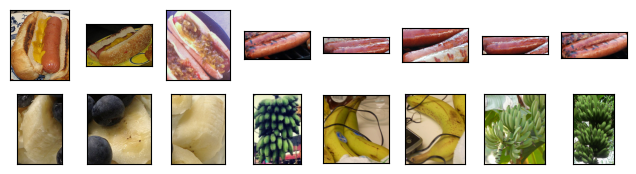

In [ ]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1)

**数据增广**

In [ ]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]  # 分别为均值和方差
)

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize,
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])

#### 定义和初始化模型
- 使用ImageNet数据集上预训练的ResNet-18作为源模型
  - 指定`pretrained=True`以自动下载预训练的模型参数
- `named_parameters()`返回模型中所有可训练参数的名称和参数本身

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0043,  0.0159, -0.0417,  ..., -0.0761, -0.0511,  0.0089],
        [ 0.0472, -0.0697,  0.0726,  ...,  0.0508, -0.0195,  0.0074]],
       requires_grad=True)

#### 微调模型
- 使用**`weight_decay`**权重衰退
- pytorch中可以为优化器传入一个**包含多个参数组的列表**，每个参数组可以有不同的优化超参数

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epoch=5, param_group=True):
  train_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(
          os.path.join(data_dir, 'train'), transform=train_augs
      ),
      batch_size=batch_size, shuffle=True,
  )
  test_iter = torch.utils.data.DataLoader(
      torchvision.datasets.ImageFolder(
          os.path.join(data_dir, 'test'), transform=test_augs,
      ),
      batch_size=batch_size
  )
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction='none')
  if param_group:
    param_1x = [param for name, param in net.named_parameters()
      if name not in ['fc.weight', 'fc.bias']]
    trainer = torch.optim.SGD([
      {'params': params_1x},
      {'params': net.fc.parameters(), 'lr': learning_rate * 10}
    ], lr = learning_rate, weight_decay=0.001,)
  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
  d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

与**所有模型参数初始化为随机值**进行比较

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-3)

### 练习

1. 继续提高`finetune_net`的学习率，模型的准确性如何变化？

In [1]:
!pip install d2l

In [2]:
import os
import torch
import torchvision

from torch import nn
from d2l import torch as d2l

In [3]:
import hashlib
import os
import requests
import tarfile
import zipfile

data_dir_drive = '/content/drive/My Drive/ColabData/'

def download(name, cache_dir=os.path.join(data_dir_drive, 'data')):
  assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}中。"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()  # 创建一个SHA-1哈希对象
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)  # 以每次 1 MB 的块大小读取
        if not data:  # data为空，文件读取完毕
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # 文件已经存在且完整
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

def download_extract(name, folder=None):
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    with zipfile.ZipFile(fname, 'r') as z:
      z.extractall(base_dir)  # 解压`zip`文件中所有内容，并放在`base_dir`路径下
  elif ext in ('.tar', '.gz'):
    with tarfile.open(fname, 'r') as t:
      t.extractall(base_dir)
  else:
    raise ValueError('只有zip/tar文件可以被解压缩。')
  return os.path.join(base_dir, folder) if folder else data_dir

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
DATA_HUB = d2l.DATA_HUB

# data_dir = download_extract('hotdog')

data_dir = '/content/drive/My Drive/ColabData/data/hotdog'
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))


In [5]:
d2l.try_all_gpus()

[device(type='cuda', index=0)]

In [6]:
normlize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normlize
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normlize
])

def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=10, param_group=True):
  train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
    batch_size=batch_size, shuffle=True
  )
  test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
    batch_size=batch_size
  )
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction='none')
  if param_group:  # 输出层中的模型参数将使用十倍的学习率
    params_1x = [param for name, param in net.named_parameters()
      if name not in ['fc.weight', 'fc.bias']
    ]
    trainer = torch.optim.SGD([
      {'params': params_1x},
      {'params': net.fc.parameters(), 'lr': learning_rate * 10}
    ], lr=learning_rate, weight_decay=0.001
    )
  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
  d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


Parameter containing:
tensor([[ 0.0994, -0.0843,  0.0602,  ...,  0.0953,  0.0241,  0.0081],
        [ 0.1054, -0.0352, -0.0994,  ...,  0.0822, -0.0970,  0.0437]],
       requires_grad=True)

loss 0.113, train acc 0.954, test acc 0.943
358.8 examples/sec on [device(type='cuda', index=0)]


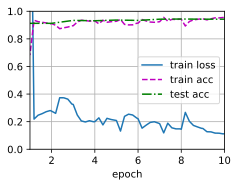

In [7]:
train_fine_tuning(finetune_net, 5e-5)

loss 0.394, train acc 0.818, test acc 0.834
379.2 examples/sec on [device(type='cuda', index=0)]


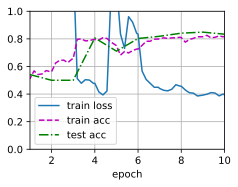

In [10]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

train_fine_tuning(finetune_net, 5e-4)

loss 0.747, train acc 0.663, test acc 0.765
379.9 examples/sec on [device(type='cuda', index=0)]


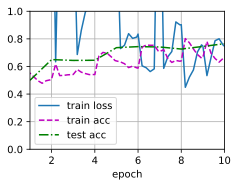

In [11]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

train_fine_tuning(finetune_net, 5e-3)

2. 在比较实验中进一步调整`finetune_net`和`scratch_net`的超参数，准确性有什么变化

loss 0.143, train acc 0.948, test acc 0.934
375.5 examples/sec on [device(type='cuda', index=0)]


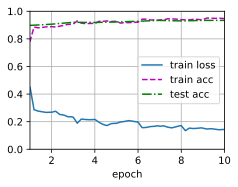

In [12]:
# 没有`param_group`
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

train_fine_tuning(finetune_net, 5e-5, param_group=False)

loss 0.326, train acc 0.857, test acc 0.856
373.0 examples/sec on [device(type='cuda', index=0)]


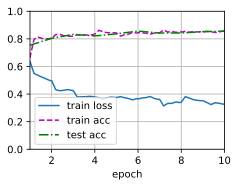

In [13]:
scrach_net = torchvision.models.resnet18()
scrach_net.fc = nn.Linear(scrach_net.fc.in_features, 2)

train_fine_tuning(scrach_net, 5e-5, param_group=False)

loss 0.354, train acc 0.836, test acc 0.848
372.2 examples/sec on [device(type='cuda', index=0)]


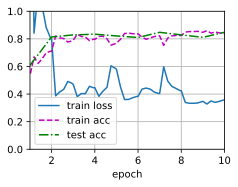

In [14]:
scrach_net = torchvision.models.resnet18()
scrach_net.fc = nn.Linear(scrach_net.fc.in_features, 2)

train_fine_tuning(scrach_net, 5e-5, param_group=True)

3. 将输出层`finetune_net`之前的参数设置为源模型的参数，在训练期间不要更新。模型的准确性如何变化？


```
for param in finetune_net.parameters():
  param.requires_grad=False
```



In [20]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=10, param_group=True):
  train_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_augs),
    batch_size=batch_size, shuffle=True
  )
  test_iter = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_augs),
    batch_size=batch_size
  )
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction='none')
  if param_group:
    param_lx = []
    for name, param in net.named_parameters():
      if name not in ['fc.weight', 'fc.bias']:
        param_lx.append(param)
        param.requires_grad = False
    trainer = torch.optim.SGD([
        {'params': param_lx},
        {'params': net.fc.parameters(), 'lr': learning_rate * 10}
    ], lr=learning_rate, weight_decay=0.001
    )
  else:
    trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
  d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0963,  0.0498,  0.0579,  ...,  0.0858,  0.0178, -0.0391],
        [ 0.0124, -0.0702,  0.0343,  ..., -0.0160,  0.0688,  0.0065]],
       requires_grad=True)

loss 0.340, train acc 0.885, test acc 0.929
1027.2 examples/sec on [device(type='cuda', index=0)]


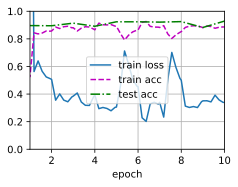

In [21]:
train_fine_tuning(finetune_net, 5e-5)

4. 事实上`ImageNet`数据流中有‘热狗’类别，可以通过如下代码获取其输出层中的相应权重参数，但是如何利用这个权重参数？

```
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape
```

- `torch.split(tensor, split_size, dim=0)`：将张量沿着某个维度拆分为多个子张量的方法
- `weight.data`的形状为`(num_classes, num_features)
  - `fc`若是一个1000分类的全连接层，则`weight.data`的形状可能是`(1000, 2048)`
- `hotdog_w`的形状是`(1, 512)`
- `nn.init.xavier_uniform_`权重初始化后形状为`(2, 512)`

只初始化第一行权重：  
- 是二分类问题，0类对应目标类（热狗），直接使用预训练模型中的‘热狗’权重，能帮助模型快速学习与‘热狗’相关的特征

In [25]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]

finetune_net = torchvision.models.resnet18()
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)
finetune_net.fc.weight.data[0] = hotdog_w.data.reshape(-1)  # 替换第0行权重

# train_fine_tuning(finetune_net, 5e-5)

In [35]:
all_images = torchvision.datasets.CIFAR10(train=True, root='../data', download=True)

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

def apply(img, aug, num_rows, num_cols, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train,
                      transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)
  return dataloader

def train_batch_ch13(net, X, y, loss, trainer, devices):
  """用多GPU进行小批量训练"""
  if isinstance(X, list):
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])

  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(
    xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
    legend=['train loss', 'train acc', 'test acc']
  )
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
        f'{str(devices)}')

batch_size = 256
devices = d2l.try_all_gpus()
net = d2l.resnet18(10, 3)

def init_weights(m):
  if type(m) in (nn.Linear, nn.Conv2d):
    nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

def train_with_data_augs(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction='none')
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

Files already downloaded and verified


loss 0.097, train acc 0.966, test acc 0.800
1130.1 examples/sec on [device(type='cuda', index=0)]


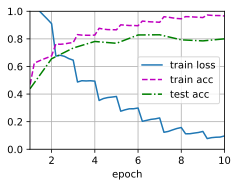

In [36]:
train_with_data_augs(test_augs, test_augs, net)

loss 0.062, train acc 0.979, test acc 0.853
1134.4 examples/sec on [device(type='cuda', index=0)]


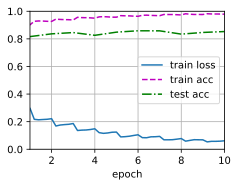

In [37]:
net = d2l.resnet18(10, 3)
train_with_data_augs(train_augs, test_augs, net)

loss 0.186, train acc 0.935, test acc 0.832
1140.6 examples/sec on [device(type='cuda', index=0)]


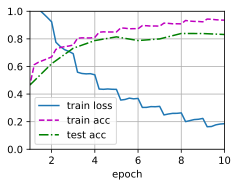

In [40]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation((-10, 10)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

net = d2l.resnet18(10, 3)
train_with_data_augs(train_augs, test_augs, net)